In [37]:
import pandas as pd

In [38]:
data = pd.read_csv("FTIR_classification.csv")

In [39]:
data.head()

,ID,"3992,6","3990,7","3988,8","3986,8","3984,9","3983,0","3981,1","3979,1","3977,2",...,Substance,Natural /Synthetic,Plastic/other,framework,Abbreviation,Source,Source ID,Form,Colour,Method
0,1,"9,5E-04","8,7E-04","8,0E-04","7,4E-04","7,1E-04","6,8E-04","6,3E-04","5,9E-04","5,5E-04",...,1_2_polybutadiene,synthetic polymer,plastic,polybutadiene,1_2_polybutadiene,"Scientific Polymer Products, Inc.",688,beads,transparent,ATR
1,2,"1,0E-03","9,8E-04","9,4E-04","9,0E-04","8,3E-04","7,8E-04","7,3E-04","6,5E-04","6,0E-04",...,acrylonitrile_butadiene_styrene,synthetic polymer,plastic,acrylonitrile butadiene styrene,ABS,RSH Polymere,NaN,foil,light brown,ATR
2,3,"7,8E-04","7,4E-04","7,3E-04","7,3E-04","7,2E-04","6,9E-04","6,6E-04","6,0E-04","5,2E-04",...,acrylonitrile_butadiene_styrene,synthetic polymer,plastic,acrylonitrile butadiene styrene,ABS,RSH Polymere,NaN,foil,light brown,ATR
3,4,"3,1E-04","2,9E-04","2,8E-04","2,9E-04","3,0E-04","2,7E-04","2,5E-04","2,6E-04","2,6E-04",...,fibre_acetate,synthetic polymer,modified cellulose,cellulose acetate,fibre_acetate,Faserinstitut Bremen,NaN,fibre,white,ATR
4,5,"3,1E-04","3,0E-04","2,7E-04","2,3E-04","2,2E-04","2,2E-04","1,9E-04","1,8E-04","1,6E-04",...,acrylonitrile_butadiene,synthetic polymer,plastic,acrylonitrile butadiene,acrylonitrile_butadiene,"Scientific Polymer Products, Inc.",530,crumbs,yellow,ATR


We drop the collumns we don't need. We will however keep the exact substance type.

In [40]:
data["is_plastic"] = (data["Plastic/other"].str.lower() == "plastic").astype(int)
data = data.drop(['Form', 'Plastic/other', 'Source ID', 'Method', 'Natural /Synthetic', 'Source'], axis=1)

In [41]:
data.head()

,ID,"3992,6","3990,7","3988,8","3986,8","3984,9","3983,0","3981,1","3979,1","3977,2",...,"405,0","403,1","401,2",Unnamed: 1864,ID.1,Substance,framework,Abbreviation,Colour,is_plastic
0,1,"9,5E-04","8,7E-04","8,0E-04","7,4E-04","7,1E-04","6,8E-04","6,3E-04","5,9E-04","5,5E-04",...,"1,7E-04","1,8E-04","4,0E-05",NaN,1,1_2_polybutadiene,polybutadiene,1_2_polybutadiene,transparent,1
1,2,"1,0E-03","9,8E-04","9,4E-04","9,0E-04","8,3E-04","7,8E-04","7,3E-04","6,5E-04","6,0E-04",...,"0,0E+00","3,9E-05","9,2E-06",NaN,2,acrylonitrile_butadiene_styrene,acrylonitrile butadiene styrene,ABS,light brown,1
2,3,"7,8E-04","7,4E-04","7,3E-04","7,3E-04","7,2E-04","6,9E-04","6,6E-04","6,0E-04","5,2E-04",...,"1,5E-02","1,0E-02","4,8E-03",NaN,3,acrylonitrile_butadiene_styrene,acrylonitrile butadiene styrene,ABS,light brown,1
3,4,"3,1E-04","2,9E-04","2,8E-04","2,9E-04","3,0E-04","2,7E-04","2,5E-04","2,6E-04","2,6E-04",...,"6,5E-04","9,8E-05","0,0E+00",NaN,4,fibre_acetate,cellulose acetate,fibre_acetate,white,0
4,5,"3,1E-04","3,0E-04","2,7E-04","2,3E-04","2,2E-04","2,2E-04","1,9E-04","1,8E-04","1,6E-04",...,"5,1E-04","3,3E-04","7,3E-05",NaN,5,acrylonitrile_butadiene,acrylonitrile butadiene,acrylonitrile_butadiene,yellow,1


In [42]:
data = data.drop(['Unnamed: 1864', 'ID.1' ], axis = 1)

In [43]:
data.head()

,ID,"3992,6","3990,7","3988,8","3986,8","3984,9","3983,0","3981,1","3979,1","3977,2",...,"408,9","407,0","405,0","403,1","401,2",Substance,framework,Abbreviation,Colour,is_plastic
0,1,"9,5E-04","8,7E-04","8,0E-04","7,4E-04","7,1E-04","6,8E-04","6,3E-04","5,9E-04","5,5E-04",...,"2,0E-04","1,3E-04","1,7E-04","1,8E-04","4,0E-05",1_2_polybutadiene,polybutadiene,1_2_polybutadiene,transparent,1
1,2,"1,0E-03","9,8E-04","9,4E-04","9,0E-04","8,3E-04","7,8E-04","7,3E-04","6,5E-04","6,0E-04",...,"2,9E-04","9,2E-05","0,0E+00","3,9E-05","9,2E-06",acrylonitrile_butadiene_styrene,acrylonitrile butadiene styrene,ABS,light brown,1
2,3,"7,8E-04","7,4E-04","7,3E-04","7,3E-04","7,2E-04","6,9E-04","6,6E-04","6,0E-04","5,2E-04",...,"2,5E-02","2,0E-02","1,5E-02","1,0E-02","4,8E-03",acrylonitrile_butadiene_styrene,acrylonitrile butadiene styrene,ABS,light brown,1
3,4,"3,1E-04","2,9E-04","2,8E-04","2,9E-04","3,0E-04","2,7E-04","2,5E-04","2,6E-04","2,6E-04",...,"1,2E-03","9,5E-04","6,5E-04","9,8E-05","0,0E+00",fibre_acetate,cellulose acetate,fibre_acetate,white,0
4,5,"3,1E-04","3,0E-04","2,7E-04","2,3E-04","2,2E-04","2,2E-04","1,9E-04","1,8E-04","1,6E-04",...,"3,2E-04","4,5E-04","5,1E-04","3,3E-04","7,3E-05",acrylonitrile_butadiene,acrylonitrile butadiene,acrylonitrile_butadiene,yellow,1


We will separate the numerical collumns corresponding to the FTIR data from the categorical variables from the rest of the features.

In [44]:
print(data.columns[-5:])

spec_cols = data.columns[1:-5]
len(spec_cols), spec_cols[:5]

Index(['Substance', 'framework', 'Abbreviation', 'Colour', 'is_plastic'], dtype='object')


(1863,
 Index(['3992,6', '3990,7', '3988,8', '3986,8', '3984,9'], dtype='object'))

In [45]:
for col in spec_cols:
    #we just convert the comas to dots first for processing
    #then we need to tranform to actual numerical values
    data[col] = (data[col].astype(str).str.replace(",", ".", regex=False))
    data[col] = pd.to_numeric(data[col], errors="coerce")

In [46]:
data.head()

,ID,"3992,6","3990,7","3988,8","3986,8","3984,9","3983,0","3981,1","3979,1","3977,2",...,"408,9","407,0","405,0","403,1","401,2",Substance,framework,Abbreviation,Colour,is_plastic
0,1,0.00095,0.00087,0.00080,0.00074,0.00071,0.00068,0.00063,0.00059,0.00055,...,0.00020,0.000130,0.00017,0.000180,0.000040,1_2_polybutadiene,polybutadiene,1_2_polybutadiene,transparent,1
1,2,0.00100,0.00098,0.00094,0.00090,0.00083,0.00078,0.00073,0.00065,0.00060,...,0.00029,0.000092,0.00000,0.000039,0.000009,acrylonitrile_butadiene_styrene,acrylonitrile butadiene styrene,ABS,light brown,1
2,3,0.00078,0.00074,0.00073,0.00073,0.00072,0.00069,0.00066,0.00060,0.00052,...,0.02500,0.020000,0.01500,0.010000,0.004800,acrylonitrile_butadiene_styrene,acrylonitrile butadiene styrene,ABS,light brown,1
3,4,0.00031,0.00029,0.00028,0.00029,0.00030,0.00027,0.00025,0.00026,0.00026,...,0.00120,0.000950,0.00065,0.000098,0.000000,fibre_acetate,cellulose acetate,fibre_acetate,white,0
4,5,0.00031,0.00030,0.00027,0.00023,0.00022,0.00022,0.00019,0.00018,0.00016,...,0.00032,0.000450,0.00051,0.000330,0.000073,acrylonitrile_butadiene,acrylonitrile butadiene,acrylonitrile_butadiene,yellow,1


To avoid deleting any rows which contain NaN values (however only 3) we will still fill those ones with the median value from that collumn.

We dont want to lose any entries as there are not many anyways (325)

In [47]:
data.isna().sum()

data[spec_cols] = data[spec_cols].fillna(data[spec_cols].median())

It's all good for now the entires are numeric values.

Now as usual Y would be our target variable which is the binary class if it's a plastic or not.

The independ variable X will consist only of spectra sequences.

We also drop collumns with identical values (which should not happen anyways), but we need to make sure to not have them for the PCA analysis, also for a binary classification method this would be just a duplicate.

In [48]:
y = data["is_plastic"]
X = data[spec_cols].copy()

#no NAN values so we drop that collumns whith NAN's
X = X.dropna(axis=1, how="all")

#if sd = 0 means two collumns are the same so we can drop them as discussed
X = X.loc[:, X.std(axis=0) > 0]

print("X shape after cleaning:", X.shape)


X shape after cleaning: (325, 1863)


We only lost 6 collumns out of 1869 so we can easily proceed with this approach.

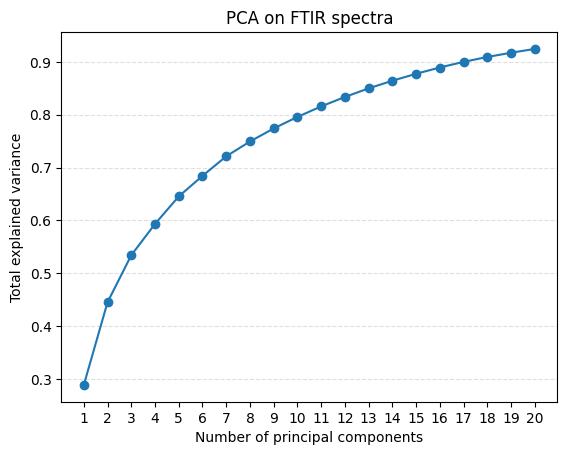

In [49]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt


n_comp = 20

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()
pca = PCA(n_components=n_comp)

pipe = make_pipeline(imputer, scaler, pca)

pipe.fit(X)

pca_step = pipe.named_steps["pca"]

#explained_variance_ratio_ = array [r1, r2 etc]
#where r1 = variance explained by PC1
#etc

expl_var = pca_step.explained_variance_ratio_
#variance exaplined by first x PC components. In our case we go until 16
cum_expl_var = expl_var.cumsum()


plt.plot(range(1, n_comp + 1), cum_expl_var, marker="o")
plt.xlabel("Number of principal components")
plt.ylabel("Total explained variance")
plt.title("PCA on FTIR spectra")
plt.xticks(range(1, n_comp + 1))
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


We can clearly see that using only 20 PCs we can explain around 95% of the variance from the full FTIR spectra of 325 samples. This means that we don’t need all 1863 original wavelength features to describe how the spectra changes between samples – most of the is already captured by these 17 linear components.



---



This shows that the FTIR structure is clearly linear in the sense that a relatively small number of linear combinations of the original features (the principal components) can represent almost all of the variation in the data. So collumns in the wavelengths are highly correlated between themselves.


Is the classes boundary (plastic or not) linear? We can first fit a simple linear model and see if the performance is good.

# **Reducing the data to only 20 principal components - to avoid overfitting**

As we have a small number of samples (325) and huge number of collumns for the wavelength feature, the risk of overfitting is huge. For this reason we will only use the best 20 Principal Components which we've seen they already explain around 95% variance of the total data.

How is the class balance we try to predict is the next big question. This matters a lot when we split our data into trianing and test.

For example we can have PC1=a1​⋅x3992.6​+a2​⋅x3990.7​+⋯+a1863​⋅x401 being a linear combinatio of the initial features, which would explain the most variance.


After seeing the classes are unbalanced (double the ratio of plastics) we decided to use Stratified K Fold Cross validation to mantain the distribution of labels in each fold.

https://www.geeksforgeeks.org/machine-learning/stratified-k-fold-cross-validation/

This will improve generalization and would make the results more relaible.

"For example, if your original dataset had 80% Class 0 and 20% Class 1 your folds would reflect the same proportion of classes in your data. This creates improved and more reliable accuracy metrics."

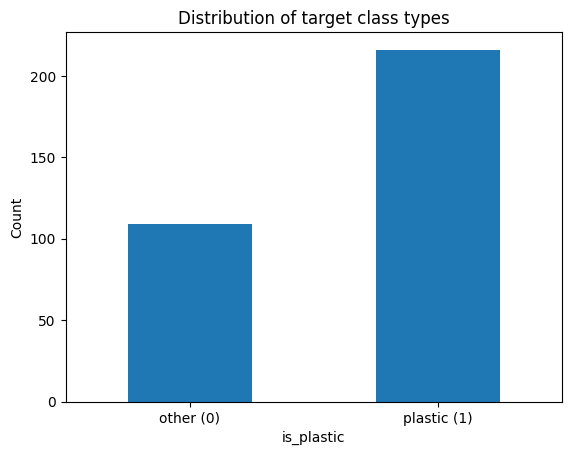

In [50]:
counts = data["is_plastic"].value_counts().sort_index()

ax = counts.plot(kind="bar")
ax.set_xticklabels(["other (0)", "plastic (1)"], rotation=0)
plt.ylabel("Count")
plt.title("Distribution of target class types")
plt.show()

In [51]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score

def evaluate_model_with_pca_cv(X, y, model, n_pcs=20, n_splits=5, random_state=42):
#this method was LLM generated based on a previous code to make a method from it
#for code re-usability

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    f1_scores = []

    all_true = []
    all_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]


        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_val_scaled = scaler.transform(X_val)

        pca = PCA(n_components=n_pcs)
        X_tr_pca = pca.fit_transform(X_tr_scaled)
        X_val_pca = pca.transform(X_val_scaled)


        clf = model.__class__(**model.get_params())
        clf.fit(X_tr_pca, y_tr)

        y_val_pred = clf.predict(X_val_pca)
        f1 = f1_score(y_val, y_val_pred)
        f1_scores.append(f1)


        y_val_scores = clf.predict_proba(X_val_pca)[:, 1]
        all_true.extend(y_val.to_numpy())
        all_scores.extend(y_val_scores)

    mean_f1 = sum(f1_scores) / len(f1_scores)


    fpr, tpr, _ = roc_curve(all_true, all_scores)
    auc = roc_auc_score(all_true, all_scores)

    return mean_f1, f1_scores, fpr, tpr, auc


"Understanding the class_weight Parameter
The class_weight parameter in Scikit-learn is used to assign weights to the classes in the data. This is particularly useful when you have an imbalanced dataset. By assigning a higher weight to the minority class and a lower weight to the majority class, the model is forced to pay more attention to the minority class during training."  - https://www.geeksforgeeks.org/machine-learning/how-does-the-classweight-parameter-in-scikit-learn-work/

In [52]:
log_reg = LogisticRegression(class_weight="balanced", max_iter=1000)


mean_f1, f1_scores, fpr, tpr, auc = evaluate_model_with_pca_cv(X, y, model=log_reg, n_pcs=20)

print("Mean F1:", mean_f1)


Mean F1: 0.8730427985147549


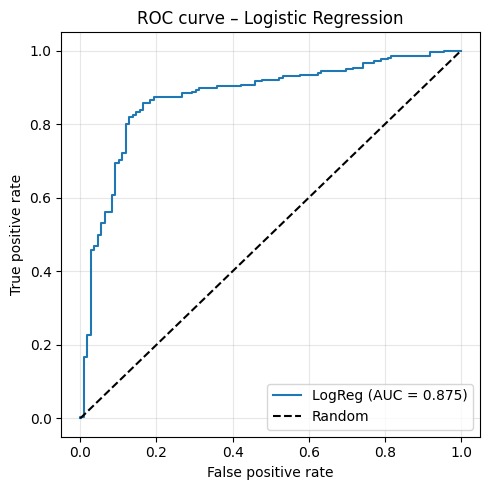

In [53]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"LogReg (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve – Logistic Regression")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [54]:
from sklearn.tree import DecisionTreeClassifier


dt = DecisionTreeClassifier(max_depth=10, min_samples_split=2, class_weight="balanced", random_state=42)

mean_f1_dt, f1_scores_dt, fpr_dt, tpr_dt, auc_dt = evaluate_model_with_pca_cv(X, y, model=dt, n_pcs=20, n_splits=5, random_state=42)


print("Decision tree - Mean F1:", mean_f1_dt)

Decision tree - Mean F1: 0.8744322870277335


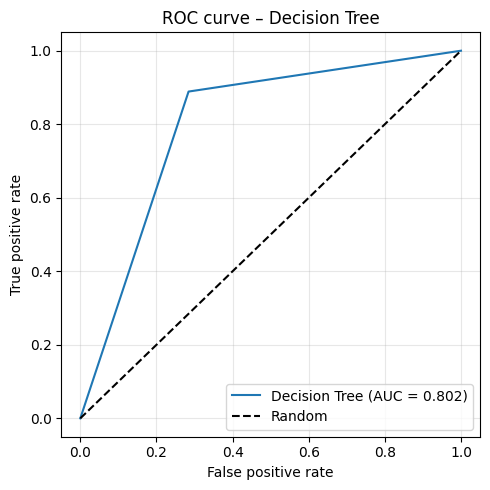

In [55]:
plt.figure(figsize=(5, 5))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve – Decision Tree")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

We get about 90% TPR with ~20% FPR. This is why it looks strange and not so smooth + there's no such thing as threshold in Decision Trees.

https://stats.stackexchange.com/questions/105760/how-we-can-draw-an-roc-curve-for-decision-trees


Also an LLM explanation: If the tree gives only a few distinct probabilities, ROC will have only a few meaningful points between (0,0) and (1,1). That’s why your curve looks like an “L” with just one or two bends.

# **Next model choice**

Most of the collumns are linearly dependent (seen from the 20 PC components explaining 95% of variance), but that doesn't mean exactly the classes are also linearly separable. The logistic regression model showed a balanced performance but still place for improvement (considering also it's just a binary classification problem).

The decision tree can handle non linear data but the performance was again very similar. This might be due to the fact they are very data hungry and we only have 325 samples (which 20% go to training in each fold).

A svm with the kernel to handle non linear relationships would create smoother curves around the deicison line boundry and might be a better suit for this problem. They are also good in general for smaller datsets comparing to decision tres.



---


https://www.geeksforgeeks.org/python/rbf-svm-parameters-in-scikit-learn/




In [56]:
from sklearn.svm import SVC

#he C parameter controls the trade-off between achieving a low training error and a low testing error, with a high value of C indicating a preference for a low training error over a low testing error.
#The gamma parameter controls the shape of the decision boundary, with a high value of gamma resulting in a more complex and wiggly boundary.
svm_rbf = SVC(kernel="rbf",C=1.5, gamma="scale", class_weight="balanced", probability=True,random_state=42)

mean_f1_svm, f1_scores_svm, fpr_svm, tpr_svm, auc_svm = evaluate_model_with_pca_cv(X, y, model=svm_rbf, n_pcs=20, n_splits=5, random_state=42)

print("SVM  - Mean F1:", mean_f1_svm)


SVM  - Mean F1: 0.9020111128246308


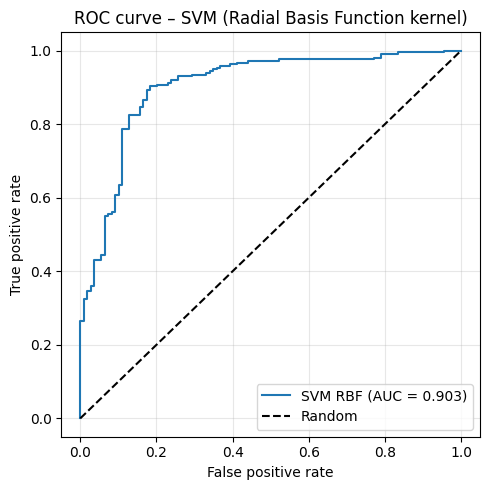

In [57]:
plt.figure(figsize=(5, 5))
plt.plot(fpr_svm, tpr_svm, label=f"SVM RBF (AUC = {auc_svm:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve – SVM (Radial Basis Function kernel)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

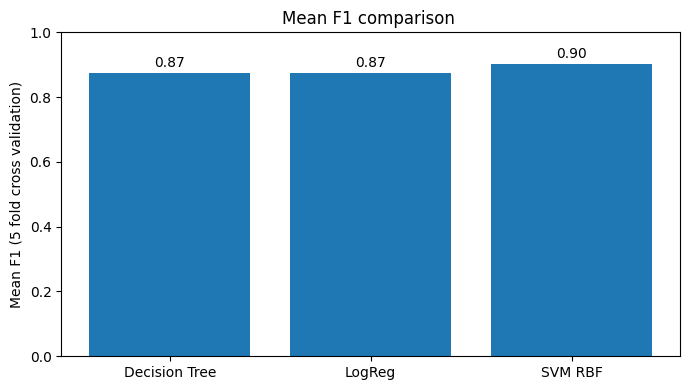

In [64]:
models = ["Decision Tree", "LogReg", "SVM RBF"]
mean_f1s = [mean_f1_dt, mean_f1, mean_f1_svm]

plt.figure(figsize=(7, 4))
bars = plt.bar(models, mean_f1s)

plt.ylabel("Mean F1 (5 fold cross validation)")
plt.ylim(0, 1.0)
plt.title("Mean F1 comparison ")

# Optional: show value on top of each bar
for bar, val in zip(bars, mean_f1s):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f"{val:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()
